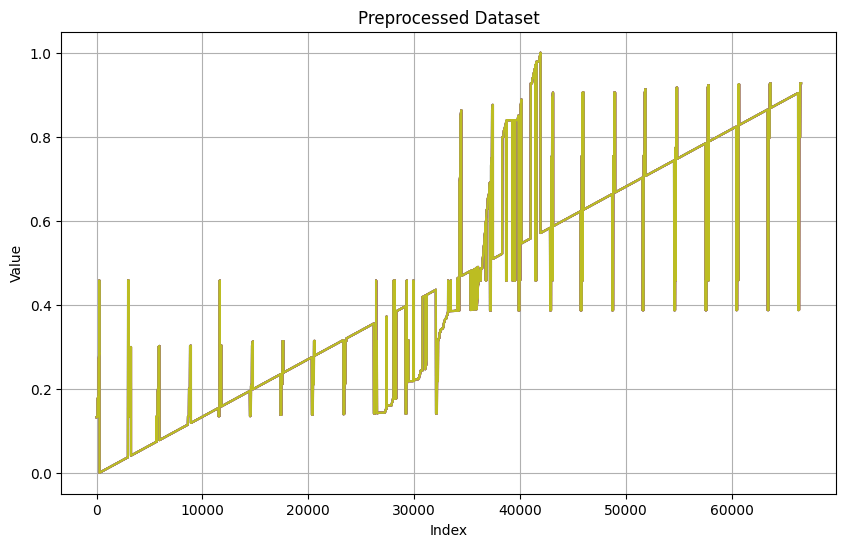

Length of X: 66572
Length of y: 66572
Shape of X_train before reshaping: (39943, 8)
Shape of X_test before reshaping: (26629, 8)
Shape of y_train before reshaping: (39943,)
Shape of y_test before reshaping: (26629,)
Shape of X_train after reshaping: (39943, 8, 1)
Shape of X_test after reshaping: (26629, 8, 1)
Shape of y_train after reshaping: (39943, 1)
Shape of y_test after reshaping: (26629, 1)
Epoch: 1
Batch 100, Loss: 0.007
Batch 200, Loss: 0.001
Batch 300, Loss: 0.015

Val Loss: 0.016
Epoch 1/25 - Lookback: 8
Train MSE: 0.2698, Train MAE: 0.4932, Train R-squared: -6.9268
Test MSE: 0.0160, Test MAE: 0.1019, Test R-squared: -0.0067

Epoch: 2
Batch 100, Loss: 0.065
Batch 200, Loss: 0.001
Batch 300, Loss: 0.015

Val Loss: 0.018
Epoch 2/25 - Lookback: 8
Train MSE: 0.3063, Train MAE: 0.5262, Train R-squared: -7.9972
Test MSE: 0.0184, Test MAE: 0.1073, Test R-squared: -0.1578

Epoch: 3
Batch 100, Loss: 0.059
Batch 200, Loss: 0.001
Batch 300, Loss: 0.015

Val Loss: 0.017
Epoch 3/25 - Look

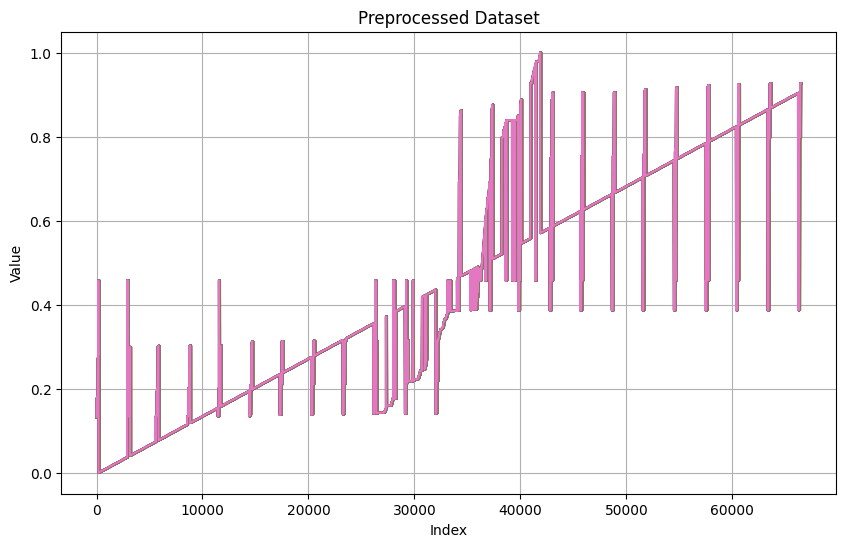

Length of X: 66484
Length of y: 66484
Shape of X_train before reshaping: (39890, 96)
Shape of X_test before reshaping: (26594, 96)
Shape of y_train before reshaping: (39890,)
Shape of y_test before reshaping: (26594,)
Shape of X_train after reshaping: (39890, 96, 1)
Shape of X_test after reshaping: (26594, 96, 1)
Shape of y_train after reshaping: (39890, 1)
Shape of y_test after reshaping: (26594, 1)
Epoch: 1
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.001

Val Loss: 0.001
Epoch 1/25 - Lookback: 96
Train MSE: 0.0049, Train MAE: 0.0650, Train R-squared: 0.8556
Test MSE: 0.0008, Test MAE: 0.0169, Test R-squared: 0.9521

Epoch: 2
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.001

Val Loss: 0.001
Epoch 2/25 - Lookback: 96
Train MSE: 0.0055, Train MAE: 0.0690, Train R-squared: 0.8384
Test MSE: 0.0007, Test MAE: 0.0147, Test R-squared: 0.9536

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.001

Val Loss: 0.001
Epoch 3/25 - Lo

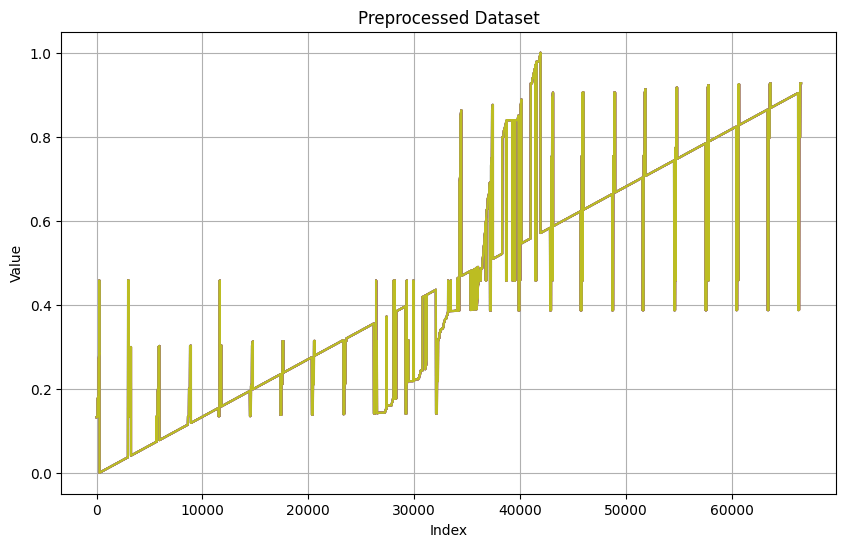

Length of X: 66572
Length of y: 66572


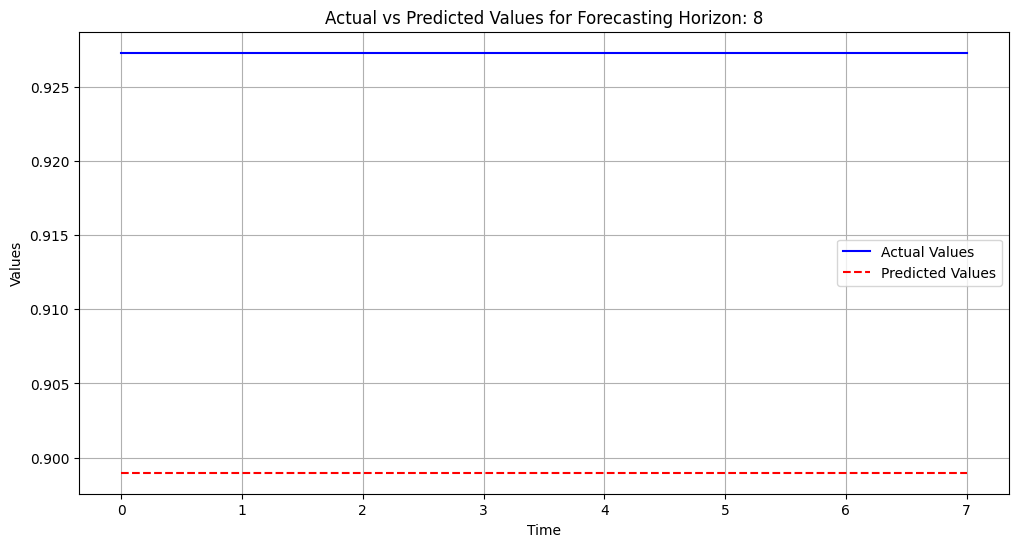

{8: array([0.89898175, 0.89898175, 0.89898175, 0.89898175, 0.89898175,
       0.89898175, 0.89898175, 0.89898175], dtype=float32)}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from prophet import Prophet
import torch.nn.functional as F

class UniconPytorch:

    def __init__(self, train_test_split_percentage: float, batch_size: int, device='cpu', num_epochs=25) -> None:
        self.data_frame = None
        self.lookback_values = [2*4, 24*4]
        self.forecasting_horizon_values = [2*4, 24*4]
        self.prepared_dataframe = None
        self.preprocessed_dataframe = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.train_test_split_percentage = train_test_split_percentage
        self.train_dataset = None
        self.test_dataset = None
        self.batch_size = batch_size
        self.device = device
        self.predictions = {}
        self.num_epochs = num_epochs
        self.model = None
        self.arima_model = None
        self.prophet_model = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.rnn_model = None

    def set_lookback(self, lookback_index):
        self.lookback = self.lookback_values[lookback_index]

    def set_forecasting_horizon(self, horizon_index):
        self.forecasting_horizon = self.forecasting_horizon_values[horizon_index]

    def load_dataset(self, link):
        self.data_frame = pd.read_csv(link)

    def load_datasets(self, file_paths):
        valid_paths = [path for path in file_paths if os.path.isfile(path)]
        if not valid_paths:
            raise ValueError("No valid file paths provided.")

        datasets = []
        for path in valid_paths:
            df = pd.read_csv(path)
            datasets.append(df)

        self.data_frame = pd.concat(datasets, ignore_index=True)

    def prepare_dataframe(self):
        df = dc(self.data_frame)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.sort_values(by=['timestamp'], inplace=True)  # Sort DataFrame by timestamp and campus_id
        df.set_index(['timestamp'], inplace=True)

        # Ensure that only the 'consumption' column is selected for preparing the dataframe
        relevant_columns = ['consumption']  # Add any other relevant columns here
        df = df[relevant_columns]


        shifted_columns = [df['consumption'].shift(self.lookback + 1 - i) for i in range(1, self.lookback + 1)]
        df_shifted = pd.concat(shifted_columns, axis=1)
        df_shifted.columns = [f'consumption(t-{self.lookback+1 - i})' for i in range(1, self.lookback + 1)]
        df = pd.concat([df, df_shifted], axis=1)

        df.dropna(inplace=True)
        self.prepared_dataframe = df.to_numpy()

    def preprocess_dataframe(self):
        self.preprocessed_dataframe = self.scaler.fit_transform(self.prepared_dataframe)
        #self.preprocessed_dataframe= self.scaler.inverse_transform(self.preprocessed_dataframe)
        plt.figure(figsize=(10, 6))
        plt.plot(self.preprocessed_dataframe)
        plt.title('Preprocessed Dataset')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()
    def create_X_y(self):
        self.X = self.preprocessed_dataframe[:, 1:]
        self.y = self.preprocessed_dataframe[:, 0]
        print("Length of X:", len(self.X))
        print("Length of y:", len(self.y))

    def create_train_test_sets(self):
        split_index = int(len(self.X) * self.train_test_split_percentage)
        self.X_train = self.X[:split_index]
        self.X_test = self.X[split_index:]
        self.y_train = self.y[:split_index]
        self.y_test = self.y[split_index:]

        print("Shape of X_train before reshaping:", self.X_train.shape)
        print("Shape of X_test before reshaping:", self.X_test.shape)
        print("Shape of y_train before reshaping:", self.y_train.shape)
        print("Shape of y_test before reshaping:", self.y_test.shape)

        self.X_train = self.X_train.reshape((-1, self.lookback, 1))
        self.X_test = self.X_test.reshape((-1, self.lookback, 1))
        self.y_train = self.y_train.reshape((-1, 1))
        self.y_test = self.y_test.reshape((-1, 1))

        print("Shape of X_train after reshaping:", self.X_train.shape)
        print("Shape of X_test after reshaping:", self.X_test.shape)
        print("Shape of y_train after reshaping:", self.y_train.shape)
        print("Shape of y_test after reshaping:", self.y_test.shape)

        self.X_train = torch.tensor(self.X_train).float()
        self.y_train = torch.tensor(self.y_train).float()
        self.X_test = torch.tensor(self.X_test).float()
        self.y_test = torch.tensor(self.y_test).float()

    class TimeSeriesDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.X)

        def __getitem__(self, i):
            if i < len(self.X):
                #print(len(self.X))  # Check length of X
                #print(len(self.y))  # Check length of y
                #print(f"Index: {i}, Length of X: {len(self.X)}, Length of y: {len(self.y)}")
                return self.X[i], self.y[i]
            else:
                raise IndexError(f"Index out of bounds: {i}")

    def create_train_test_datasets(self):
        self.train_dataset = self.TimeSeriesDataset(self.X_train, self.y_train)
        self.test_dataset = self.TimeSeriesDataset(self.X_test, self.y_test)

    def create_dataloaders(self):
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    class LSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_stacked_layers, device):
            super().__init__()
            self.hidden_size = hidden_size
            self.num_stacked_layers = num_stacked_layers
            self.device = device
            self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            batch_size = x.size(0)
            h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(self.device)
            c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(self.device)
            out, _ = self.lstm(x, (h0, c0))
            out = self.fc(out[:, -1, :])
            return out

    def create_model(self):
        self.model = self.LSTM(1, 4, 2, device=self.device)
        self.model.to(self.device)

    def train_one_epoch(self, model, loss_function, optimizer, epoch):
        model.train(True)
        print(f'Epoch: {epoch + 1}')
        running_loss = 0.0

        for batch_index, batch in enumerate(self.train_loader):
            x_batch, y_batch = batch[0].to(self.device), batch[1].to(self.device)

            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_index % 100 == 99:  # print every 100 batches
                avg_loss_across_batches = running_loss / 100
                print(f'Batch {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}')
                running_loss = 0.0
        print()

    def validate_one_epoch(self, model, loss_function):
        model.train(False)
        running_loss = 0.0

        for batch_index, batch in enumerate(self.test_loader):
            x_batch, y_batch = batch[0].to(self.device), batch[1].to(self.device)

            with torch.no_grad():
                output = model(x_batch)
                loss = loss_function(output, y_batch)
                running_loss += loss.item()

        avg_loss_across_batches = running_loss / len(self.test_loader)

        print(f'Val Loss: {avg_loss_across_batches:.3f}')

    def train_model(self):
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

        for epoch in range(self.num_epochs):
            self.train_one_epoch(self.model, loss_function, optimizer, epoch)
            self.validate_one_epoch(self.model, loss_function)

    def train_model_horizons(self):
      loss_function = nn.MSELoss()
      # Create the model once outside the loop
      self.create_model()
      optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)



      for lookback_value in self.lookback_values:
          self.set_lookback(self.lookback_values.index(lookback_value))
          self.set_forecasting_horizon(self.lookback_values.index(lookback_value))  # Set forecasting horizon equal to lookback
          self.prepare_dataframe()
          self.preprocess_dataframe()
          self.create_X_y()
          self.create_train_test_sets()
          self.create_train_test_datasets()
          self.create_dataloaders()

          for epoch in range(self.num_epochs):
              self.train_one_epoch(self.model, loss_function, optimizer, epoch)
              self.validate_one_epoch(self.model, loss_function)
              # Calculate metrics on training set
              train_predictions = self.model(self.X_train).detach().numpy().flatten()
              train_mse = mean_squared_error(self.y_train, train_predictions)
              train_mae = mean_absolute_error(self.y_train, train_predictions)
              train_r2 = r2_score(self.y_train, train_predictions)

              # Calculate metrics on test set
              test_predictions = self.model(self.X_test).detach().numpy().flatten()
              test_mse = mean_squared_error(self.y_test, test_predictions)
              test_mae = mean_absolute_error(self.y_test, test_predictions)
              test_r2 = r2_score(self.y_test, test_predictions)

              print(f'Epoch {epoch + 1}/{self.num_epochs} - Lookback: {lookback_value}')
              print(f'Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}, Train R-squared: {train_r2:.4f}')
              print(f'Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}, Test R-squared: {test_r2:.4f}')
              print()

    def predict(self, forecasting_horizon):
        if not self.model:
            print("Model has not been trained yet. Please train the model before making predictions.")
            return {}

        predictions = {}
        metrics = {}

        self.set_lookback(self.forecasting_horizon_values.index(forecasting_horizon))
        self.set_forecasting_horizon(self.forecasting_horizon_values.index(forecasting_horizon))
        self.prepare_dataframe()
        self.preprocess_dataframe()
        self.create_X_y()

        # Reshape the data for prediction
        X_predict = self.X[-forecasting_horizon:]  # Use the last 'forecasting_horizon' observations for prediction
        X_predict = X_predict.reshape((-1, forecasting_horizon, 1))
        X_predict = torch.tensor(X_predict).float()

        # Set the model to evaluation mode
        self.model.eval()

        # Make predictions
        with torch.no_grad():
            scaled_predictions = self.model(X_predict).numpy().flatten()

        # Update self.predictions
        predictions[forecasting_horizon] = scaled_predictions
        self.predictions.update(predictions)

        # Calculate metrics
        actual_values = self.y[-forecasting_horizon:]
        mse = mean_squared_error(actual_values, scaled_predictions)
        mae = mean_absolute_error(actual_values, scaled_predictions)
        r2 = r2_score(actual_values, scaled_predictions)

        metrics['MSE'] = mse
        metrics['MAE'] = mae
        metrics['R2'] = r2
        # Plotting the results
        plt.figure(figsize=(12, 6))

        # Plot actual values
        plt.plot(actual_values, label='Actual Values', color='blue')

        # Plot predicted values
        plt.plot(scaled_predictions, label='Predicted Values', color='red', linestyle='--')

        # Add title and labels
        plt.title(f'Actual vs Predicted Values for Forecasting Horizon: {forecasting_horizon}')
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.legend()
        plt.grid(True)

        # Show plot
        plt.show()
        return predictions, metrics

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def train_prophet_model(self):
        # Initialize Prophet model
        self.prophet_model = Prophet()

        # Prepare DataFrame for Prophet
        df_prophet = dc(self.data_frame)
        df_prophet.rename(columns={"timestamp": "ds", "consumption": "y"}, inplace=True)

        # Fit the Prophet model
        self.prophet_model.fit(df_prophet)

    def predict_prophet(self, forecasting_horizon):
        if not self.prophet_model:
            print("Prophet model has not been trained yet. Please train the model before making predictions.")
            return {}, {}

        predictions = {}
        metrics = {}

        # Prepare DataFrame for prediction
        future = self.prophet_model.make_future_dataframe(periods=forecasting_horizon, freq='H')

        # Make predictions
        forecast = self.prophet_model.predict(future)
        predictions[forecasting_horizon] = forecast['yhat'][-forecasting_horizon:].values

        # Calculate metrics
        actual_values = self.data_frame['consumption'][-forecasting_horizon:].values
        mse = mean_squared_error(actual_values, predictions[forecasting_horizon])
        mae = mean_absolute_error(actual_values, predictions[forecasting_horizon])
        r2 = r2_score(actual_values, predictions[forecasting_horizon])

        metrics['MSE'] = mse
        metrics['MAE'] = mae
        metrics['R2'] = r2

        return predictions, metrics

    class RNN(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, device):
            super().__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.device = device
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            batch_size = x.size(0)
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
            out, _ = self.rnn(x, h0)
            out = self.fc(out[:, -1, :])
            return out

    def create_rnn_model(self):
        self.rnn_model = self.RNN(1, 4, 2, device=self.device)
        self.rnn_model.to(self.device)

    def train_rnn_model(self):
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(self.rnn_model.parameters(), lr=0.001)

        for epoch in range(self.num_epochs):
            self.train_one_epoch(self.rnn_model, loss_function, optimizer, epoch)
            self.validate_one_epoch(self.rnn_model, loss_function)

    def train_rnn_model_horizons(self):
      loss_function = nn.MSELoss()
      self.create_rnn_model()
      optimizer = torch.optim.Adam(self.rnn_model.parameters(), lr=0.01)

      for lookback_value in self.lookback_values:
          self.set_lookback(self.lookback_values.index(lookback_value))
          self.set_forecasting_horizon(self.lookback_values.index(lookback_value))  # Set forecasting horizon equal to lookback
          self.prepare_dataframe()
          self.preprocess_dataframe()
          self.create_X_y()
          self.create_train_test_sets()
          self.create_train_test_datasets()
          self.create_dataloaders()

          for epoch in range(self.num_epochs):
              self.train_one_epoch(self.rnn_model, loss_function, optimizer, epoch)
              self.validate_one_epoch(self.rnn_model, loss_function)
              # Calculate metrics on training set
              train_predictions = self.rnn_model(self.X_train).detach().numpy().flatten()
              train_mse = mean_squared_error(self.y_train, train_predictions)
              train_mae = mean_absolute_error(self.y_train, train_predictions)
              train_r2 = r2_score(self.y_train, train_predictions)

              # Calculate metrics on test set
              test_predictions = self.rnn_model(self.X_test).detach().numpy().flatten()
              test_mse = mean_squared_error(self.y_test, test_predictions)
              test_mae = mean_absolute_error(self.y_test, test_predictions)
              test_r2 = r2_score(self.y_test, test_predictions)

              print(f'Epoch {epoch + 1}/{self.num_epochs} - Lookback: {lookback_value}')
              print(f'Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}, Train R-squared: {train_r2:.4f}')
              print(f'Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}, Test R-squared: {test_r2:.4f}')
              print()

    def predict_rnn(self, forecasting_horizon):
        if not self.rnn_model:
            print("RNN model has not been trained yet. Please train the model before making predictions.")
            return {}, {}

        predictions = {}
        metrics = {}

        self.set_lookback(self.forecasting_horizon_values.index(forecasting_horizon))
        self.set_forecasting_horizon(self.forecasting_horizon_values.index(forecasting_horizon))
        self.prepare_dataframe()
        self.preprocess_dataframe()
        #self.create_X_y()

        # Reshape the data for prediction
        X_predict = self.preprocessed_dataframe[-forecasting_horizon:]  # Use the last 'forecasting_horizon' observations for prediction
        X_predict = X_predict.reshape((-1, forecasting_horizon, 1))
        X_predict = torch.tensor(X_predict).float()

        # Set the model to evaluation mode
        self.rnn_model.eval()

        # Make predictions
        with torch.no_grad():
            scaled_predictions = self.rnn_model(X_predict).numpy().flatten()

        # Update self.predictions
        predictions[forecasting_horizon] = scaled_predictions

        # Calculate metrics
        actual_values = self.y[-forecasting_horizon:]
        mse = mean_squared_error(actual_values, scaled_predictions)
        mae = mean_absolute_error(actual_values, scaled_predictions)
        r2 = r2_score(actual_values, scaled_predictions)

        metrics['MSE'] = mse
        metrics['MAE'] = mae
        metrics['R2'] = r2

        return predictions, metrics

# Example usage:
# Initialize UniconPytorch
model = UniconPytorch(train_test_split_percentage=0.6, batch_size=128)

# Load dataset
model.load_datasets(['water_consumption_1.csv'])

model.train_model_horizons()
#model.train_prophet_model()
#model.train_rnn_model_horizons()
# Forecast
model.predict(8)
#model.predict_prophet(2)
#model.predict_rnn(2)
# Save the model after training on all horizons
model.save_model("trained_model.pth")

# Access predictions
print(model.predictions)

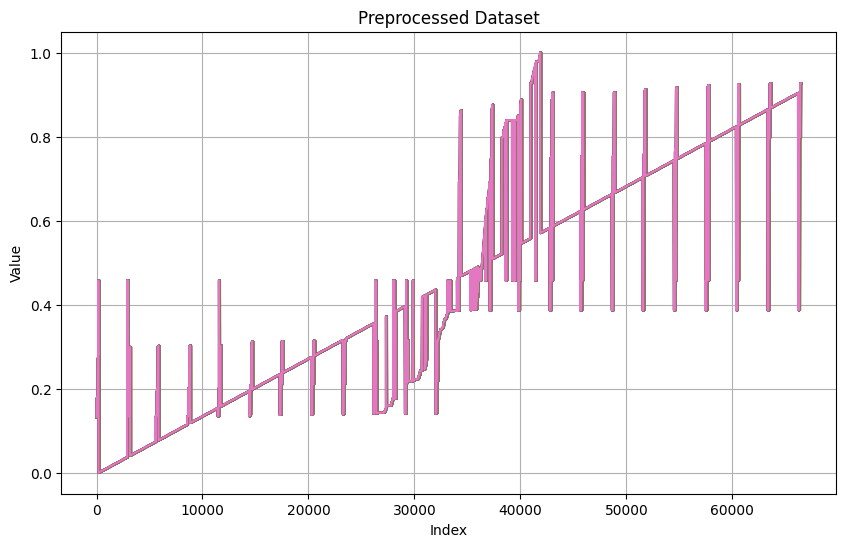

Length of X: 66484
Length of y: 66484


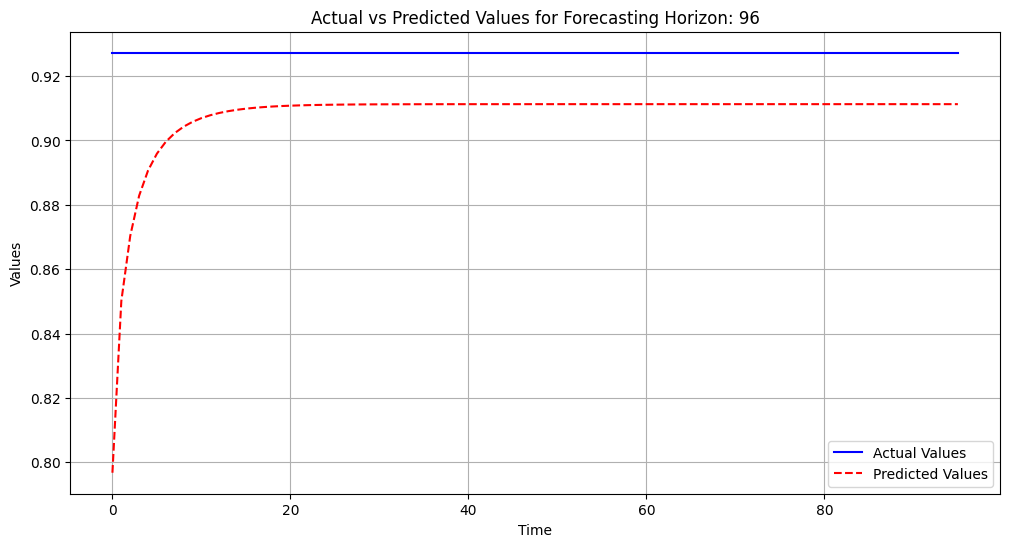

({96: array([0.7967331 , 0.8501165 , 0.87031674, 0.882825  , 0.8906468 ,
         0.89591336, 0.899612  , 0.9022951 , 0.9042885 , 0.90579635,
         0.9069531 , 0.9078501 , 0.9085513 , 0.9091032 , 0.90954   ,
         0.90988684, 0.91016346, 0.9103844 , 0.91056144, 0.91070354,
         0.91081756, 0.9109094 , 0.91098315, 0.91104275, 0.91109073,
         0.9111295 , 0.9111605 , 0.91118574, 0.91120595, 0.91122246,
         0.9112357 , 0.91124636, 0.91125494, 0.911262  , 0.91126764,
         0.9112721 , 0.9112758 , 0.9112788 , 0.91128117, 0.91128314,
         0.9112847 , 0.91128594, 0.91128695, 0.9112878 , 0.9112885 ,
         0.91128904, 0.91128945, 0.91128975, 0.91129005, 0.91129035,
         0.91129047, 0.91129065, 0.91129076, 0.9112909 , 0.91129094,
         0.911291  , 0.911291  , 0.9112912 , 0.9112911 , 0.9112912 ,
         0.9112912 , 0.91129124, 0.9112912 , 0.91129124, 0.91129124,
         0.91129124, 0.91129124, 0.91129124, 0.91129124, 0.91129124,
         0.91129124, 0.9112912

In [ ]:
model.predict(24*4)